# Semantische Themen-Analyse mit LSI/LSA und LDA

## Vorbereitung: Abhängigkeiten installieren

In [1]:
%load_ext autoreload
%autoreload 2

from helpers import *
import sys
import warnings
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
from pprint import pprint
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m spacy download de_core_news_md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/de_core_news_md-3.7.0/de_core_news_md-3.7.0-py3-none-any.whl (44.4 MB)

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


## Schritt 1: Aktuelle Daten herunterladen
Die Daten werden 1x pro Tag von `https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen` heruntergeladen und im Ordner `../data` abgelegt. Alle folgenden Ausführungen am selben Tag werden exakt diese Daten verwenden.

In [2]:
from datetime import datetime
import os
import requests
import json
import pandas as pd

current_date = datetime.now().strftime("%Y-%m-%d")
dataset_path = f"../data/{current_date}.json"
base_model_folder = f"../models/{current_date}"

if os.path.exists(dataset_path):
    print("  Data already downloaded!")
else:
    url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        with open(dataset_path, "w") as f:
            json.dump(data, f)
    else:
        print("  Error: Could not retrieve data from URL")

dataset = pd.read_json(dataset_path, orient="records", typ="series")
dataset = pd.DataFrame(
    map(
        lambda x: {
            "msg_id": x["id"],
            "betreff": x["betreff"],
            "sachverhalt": x["sachverhalt"],
        },
        dataset["index"],
    )
)

dataset.head(10)

  Data already downloaded!


,msg_id,betreff,sachverhalt
0,527563,Sperrmüll abgelagert (Spiegel),Spiegel
1,527575,Sperrmüll abgelagert (Holz-/Regalteile),Holz-/Regalteile
2,622944,Park- und Haltverbot nicht berücksichtigt,Pkw in geschützter Grünanlage aufgefahren
3,681533,Parken auf Gehweg,None
4,788708,Abfall - Müllablagerung,Bauschutt
5,883168,Gehweg/Radweg zugeparkt,None
6,885548,Park- und Haltverbot nicht berücksichtigt,Kfz steht in der kurve. Mit plane abgedeckt.
7,890996,"Parkraumbewirtschaftung - Anwohner-, Gästevign...",ca. 13.22 Uhr\n\nkeine Vignette keine Parksche...
8,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...
9,1018325,Parkraumbewirtschaftung - Sonstiges,Seit vier Tagen parkt in falscher Fahrtrichtun...


## Schritt 2: Datensatz aufteilen und Texte vorverarbeiten
In diesem Schritt erstelle ich zuerst 2 verschiedene Datensätze (einen Trainings- und einen Test-Datensatz) mit einer 80/20-Verteilung. Das Test-Set wird am Ende des Notebooks zum Testen der Modelle verwendet.

Die Texte beider Datensätze werden danach wie folgt vorverarbeitet:
* Tokenisierung
* Entfernung von Stopwörtern, Punktuation und Zahlen
* Lemmatisierung
* PoS-Tagging (Part-of-Speech)

In [3]:
from sklearn.model_selection import train_test_split
import spacy

def run_text_pipeline(df: pd.DataFrame):
    # respect both subject and free text when classifying
    docs = list(
        nlp.pipe(
            df[df.columns[1:]].apply(lambda x: " ".join(x.dropna().astype(str)), axis=1)
        )
    )
    df = tidy_tokens(docs)
    # remove short tokens and stopwords/punctuations/digits
    return (
        df.loc[
            df.lemma.apply(lambda x: len(x) > 2)
            & ~df.is_stop
            & ~df.is_punct
            & ~df.is_digit
        ]
        .groupby(["msg_id"])
        .agg(lambda x: x.values.tolist())
        .lemma
    )


# split into training, test and cross-validation set
train_data, test_data = train_test_split(dataset, test_size=0.15, random_state=200)
test_data, cv_data = train_test_split(test_data, test_size=0.5, random_state=200)

# define spacy pipeline
nlp = spacy.load(
    "de_core_news_md",
    disable=[
        "textcat",
        "transformer",
        "textcat_multilabel",
        "entity_ruler",
        "attribute_ruler",
    ],
)

# cleanup sets
training_set = run_text_pipeline(train_data).values
test_set = run_text_pipeline(test_data).values
cv_set = run_text_pipeline(cv_data).values

train_data.shape, test_data.shape, cv_data.shape

((4863, 3), (429, 3), (430, 3))

## Schritt 3: Textvektorisierung mit BoW und TF-IDF
In diesem Abschnitt vergleiche ich die zwei Textvektorisierungs-Methoden Bag-of-Words (BoW) und Term-Frequency Inverse-Document-Frequency (TF-IDF). Während Verben wie "sehen" oder "stehen" in einer reinen Wort-Frequenz-Zählung in den Top 5 rangieren, werden sie wegen ihrer generischen Natur von TF-IDF teilweise deutlich zurückgestuft.

### Variante 1: Bag-of-Words

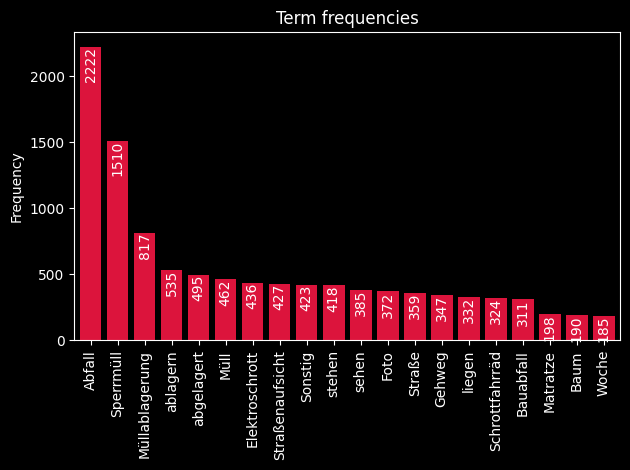

In [50]:
from helpers import get_word_freq, plot_word_freq
from gensim import corpora
import matplotlib.pyplot as plt

# create bag-of-words corpus
bow_dict = corpora.Dictionary()
bow_corpus = [bow_dict.doc2bow(doc, allow_update=True) for doc in training_set]

word_freq_bow = get_word_freq(bow_corpus, bow_dict)
plot_word_freq(word_freq_bow, 20)

### Variante 2: TF-IDF (Term-Frequency Inverse-Document-Frequency)

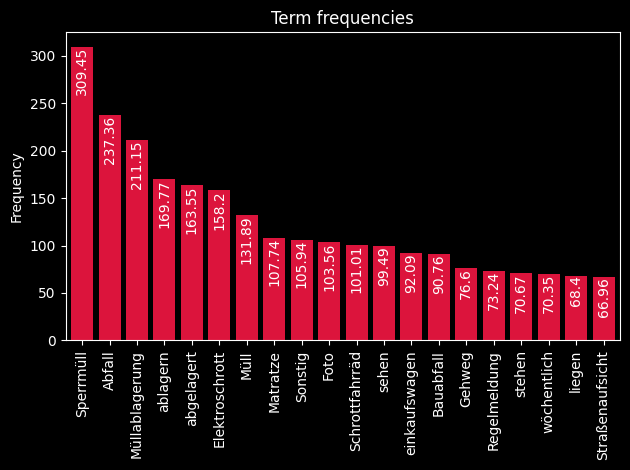

In [48]:
from gensim.models import TfidfModel

# create tf-idf model
tfidf_dict = corpora.Dictionary(training_set)
tfidf = TfidfModel(dictionary=tfidf_dict, smartirs='ntc')
tfidf_corpus = [tfidf[tfidf_dict.doc2bow(doc)] for doc in training_set]

# get overall tf-idf scores
word_freq_tfidf = get_word_freq(tfidf_corpus, tfidf_dict)
plot_word_freq(word_freq_tfidf, 20)



## Schritt 4: Modell-Training
Nun werde ich 2 verschiedene Varianten für die Themen-Extraktion vergleichen: Latent Semanting Indexing/Analysis (LSA/LSI) und Latent Dirichlet Allocation (LDA). In einem ersten Schritt werde ich für verschiedene Anzahl Themen (`num_topcs`-Parameter für das `LsiModel` resp. `LdaMulticore`) den Koheränz-Score berechnen und auf einem Diagramm visualisieren. Dies soll mir erlauben, für das spätere Modell-Training die optimale Anzahl Themen zu wählen.

### Variante 1: LSA-Modell trainieren
Zuerst werde ich versuchen, die optimale Anzahl Themenfelder anhand eines Diagramms zu eruieren.

/home/vscode/.local/lib/python3.11/site-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy

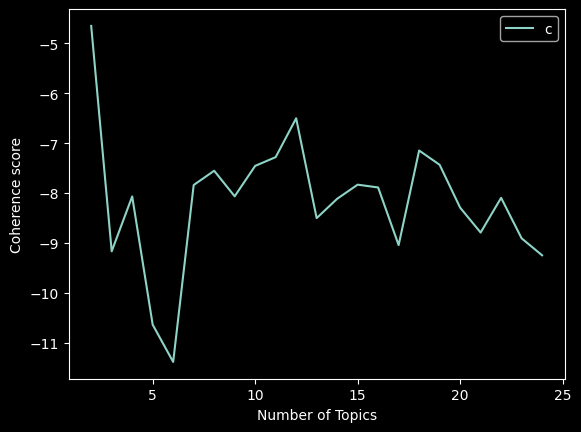

In [49]:
import gensim

lsa_dict = gensim.corpora.Dictionary(training_set)
lsa_corpus = [lsa_dict.doc2bow(doc) for doc in training_set]

start, stop, step = 2, 25, 1

_, coherence_values = compute_coherence_values(
    dict=lsa_dict,
    corpus=lsa_corpus,
    training_set=training_set,
    model_type="lsi",
    coherence="u_mass",
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Das Diagram zeigt auf, dass die optimale Anzahl Themen zwischen 4 und 5 liegt, mit höheren Werten pendelt sich der Coherence-Score auf einem höheren Niveau ein (wobei bei der u_mass Metrik der tiefste Wert der beste ist).

In [39]:
num_topics = 5

lsi_model = LsiModel(lsa_corpus, num_topics=num_topics, id2word=lsa_dict)
topics = get_specific_topics(lsi_model)

for topic_id, terms in topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

# Compute Perplexity & Coherence Score
coherence_model_lsa = CoherenceModel(
    model=lsi_model, corpus=lsa_corpus, dictionary=lsa_dict, coherence="u_mass"
)
coherence_lsa = coherence_model_lsa.get_coherence()
print("Coherence Score: ", coherence_lsa)

Topic 0:
  Abfall: -0.7461
  Sperrmüll: -0.5032
  Müllablagerung: -0.2061
  Foto: -0.1378
  sehen: -0.1352
Topic 1:
  Geräusch: 0.4944
  knallen: 0.4595
  aufeinander: 0.3352
  laut: 0.2356
  Topf: 0.2293
Topic 2:
  Sperrmüll: -0.7512
  Abfall: 0.3495
  Müllablagerung: 0.3227
  abgelagert: -0.2556
  ablagern: -0.2069
Topic 3:
  Straßenaufsicht: 0.3537
  Straße: 0.3426
  Gehweg: 0.3109
  Abfall: -0.2883
  Foto: 0.1904
Topic 4:
  Müllablagerung: 0.6551
  Müll: 0.4167
  Abfall: -0.2812
  Sonstig: -0.1986
  Schrottfahrräd: -0.1984
Coherence Score:  -7.790957070176441


## Variante 2: LDA-Modell trainieren
Als zweite Variante trainiere ich mit den Daten ein LDA-Modell (Latent Dirichlet Allocation) zur Ermittlung der Top-Themen in den Daten. Auch hier soll in einem ersten Schritt die ideale Anzahl Themen anhand des Coherence-Scores ermittelt werden (dieses mal auf Basis des `LdaMulticore`-Modells).

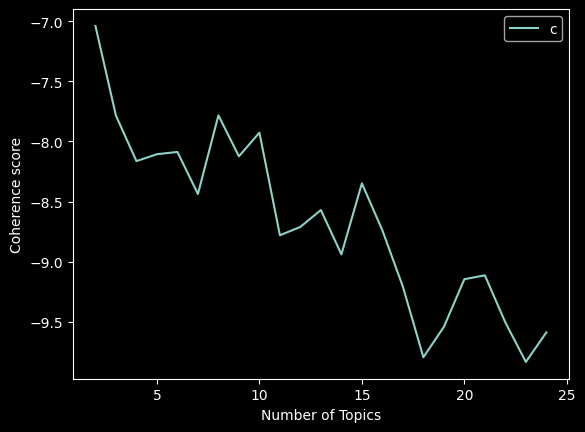

In [42]:
import gensim

lda_dict = gensim.corpora.Dictionary(training_set)
lda_corpus = [lda_dict.doc2bow(doc) for doc in training_set]

start, stop, step = 2, 25, 1
_, coherence_values = compute_coherence_values(
    dict=lda_dict,
    corpus=lda_corpus,
    model_type="lda",
    training_set=training_set,
    coherence="u_mass",
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Bei LDA zeigt sich zum einen eine tiefere Varianz in der Koheränz und zum anderen eine Verschiebung hin zu mehr Themenfelder. Wir trainieren das LDA-Modell mit 18 Themenfeldern und visualisieren die Resultate mit dem Python-Paket `pyLDAvis`, zur Evaluation wird wieder der Coherence-Score herangezogen.

In [43]:
from gensim.models import CoherenceModel, LdaMulticore
import pyLDAvis.gensim_models

num_topics = 18

lda_model = LdaMulticore(
    lda_corpus, num_topics=num_topics, id2word=lda_dict, passes=100, workers=4
)

# Compute Perplexity & Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, corpus=lda_corpus, dictionary=lda_dict, coherence="u_mass"
)
coherence_lda = coherence_model_lda.get_coherence()
print("Perplexity: ", lda_model.log_perplexity(lda_corpus))
print("Coherence Score: ", coherence_lda)

specific_topics = get_specific_topics(lda_model)
for topic_id, terms in specific_topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, lda_corpus, lda_dict, sort_topics=False)
pyLDAvis.display(vis)

Perplexity:  -7.399581806658042
Coherence Score:  -10.39968657969829
Topic 0:
  Straße: 0.0846
  Straßenaufsicht: 0.0507
  Gehwegschäder: 0.0397
  stehen: 0.0282
  Anhänger: 0.0222
Topic 1:
  Bauabfall: 0.1445
  Bauschutt: 0.0813
  Abfall: 0.0471
  ablagern: 0.0396
  abgelagert: 0.0388
Topic 2:
  Abfall: 0.1481
  Schrottfahrräd: 0.1206
  Fahrrad: 0.0363
  Reifen: 0.0264
  stehen: 0.0130
Topic 3:
  Elektroschrott: 0.1113
  Abfall: 0.1001
  Sonstig: 0.0445
  einkaufswagen: 0.0381
  abgelagert: 0.0337
Topic 4:
  Ratte: 0.0252
  Baustelle: 0.0125
  laufen: 0.0124
  Hygiene: 0.0107
  Gesundheitsschutz: 0.0107
Topic 5:
  Baum: 0.0342
  öffentlich: 0.0285
  Straßenaufsicht: 0.0256
  Straßenland: 0.0225
  Busch: 0.0205
Topic 6:
  Baustelle: 0.0319
  Gehweg: 0.0299
  Sonstig: 0.0252
  Sondernutzung: 0.0209
  fehlend: 0.0202
Topic 7:
  Spielplatz: 0.0184
  TÜV: 0.0121
  voll: 0.0113
  Straße: 0.0108
  stehen: 0.0102
Topic 8:
  Park: 0.0574
  Grünanlage: 0.0508
  Müll: 0.0306
  Verschmutzung: 0.0